In [1]:
import findspark

findspark.init()

In [2]:
from hdfs import InsecureClient
from pyspark.sql import SparkSession
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier,
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
IP = "192.168.35.128"
HOST_IP = "192.168.0.102"  # Dùng IP máy thật ở bước 8

In [4]:
# Tạo connect tới HDFS
client = InsecureClient(f"http://{IP}:9870", user="hdoop")

In [5]:
client.makedirs("dataset")

In [6]:
# Upload file vào HDFS
try:
    client.upload("dataset/heart.csv", "./dataset/heart.csv")
except Exception as e:
    print(e)

In [7]:
client.list("dataset/")

['heart.csv']

In [8]:
# Tạo spark
spark = (
    SparkSession.builder.appName("Samsung")
    .master(f"spark://{IP}:7077")
    .config("spark.driver.memory", "1g")
    .config("spark.executor.memory", "1g")
    .config("spark.executor.instances", "1")
    .config("spark.driver.host", HOST_IP)
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config("spark.driver.port", "53333")
    .getOrCreate()
)
# spark = SparkSession.builder.appName("kafka").master("local[*]").getOrCreate()

In [9]:
df = spark.read.csv(
    f"hdfs://{IP}:9000/user/hdoop/dataset/heart.csv", header=True, inferSchema=True
)
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [10]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [11]:
df.describe().show()

+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|summary|               Age| Sex|ChestPainType|         RestingBP|       Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|           Oldpeak|ST_Slope|       HeartDisease|
+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|  count|               918| 918|          918|               918|               918|                918|       918|               918|           918|               918|     918|                918|
|   mean|53.510893246187365|NULL|         NULL|132.39651416122004| 198.7995642701525|0.23311546840958605|      NULL|136.80936819172112|          NULL|0.8873638344226581|    NULL| 0.5533769063180828|
| std

In [12]:
pandas_df = df.toPandas()

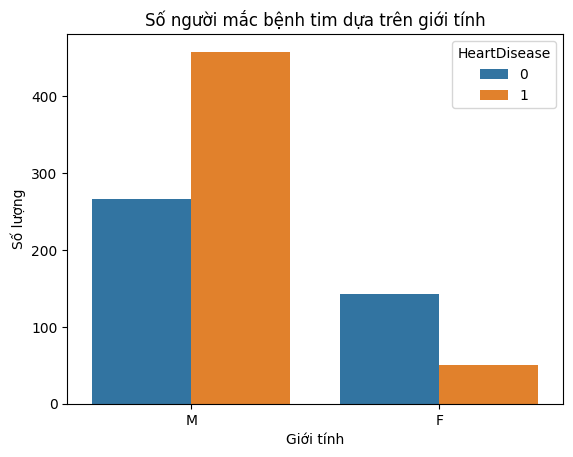

In [13]:
# Biểu đồ: Giới tính vs HeartDisease
sns.countplot(x="Sex", hue="HeartDisease", data=pandas_df)
plt.title("Số người mắc bệnh tim dựa trên giới tính")
plt.xlabel("Giới tính")
plt.ylabel("Số lượng")
plt.show()

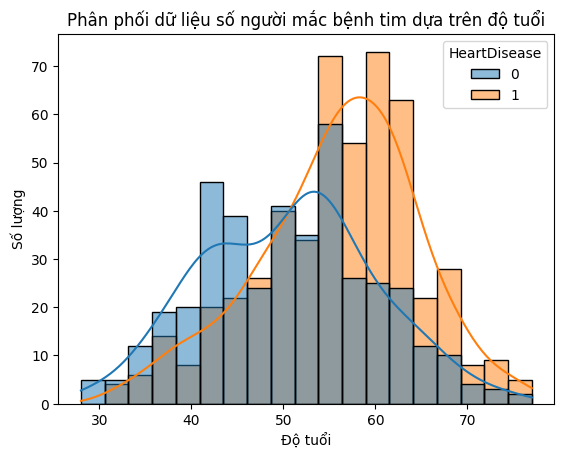

In [14]:
# Tuổi vs HeartDisease
sns.histplot(data=pandas_df, x="Age", hue="HeartDisease", kde=True)
plt.title("Phân phối dữ liệu số người mắc bệnh tim dựa trên độ tuổi")
plt.xlabel("Độ tuổi")
plt.ylabel("Số lượng")
plt.show()

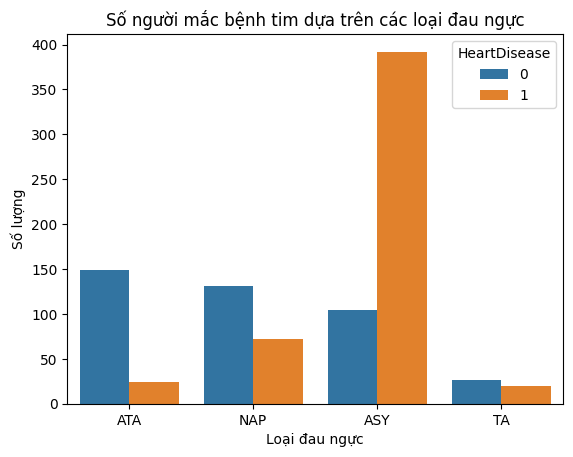

In [15]:
# ChestPainType vs HeartDisease
sns.countplot(x="ChestPainType", hue="HeartDisease", data=pandas_df)
plt.title("Số người mắc bệnh tim dựa trên các loại đau ngực")
plt.xlabel("Loại đau ngực")
plt.ylabel("Số lượng")
plt.show()

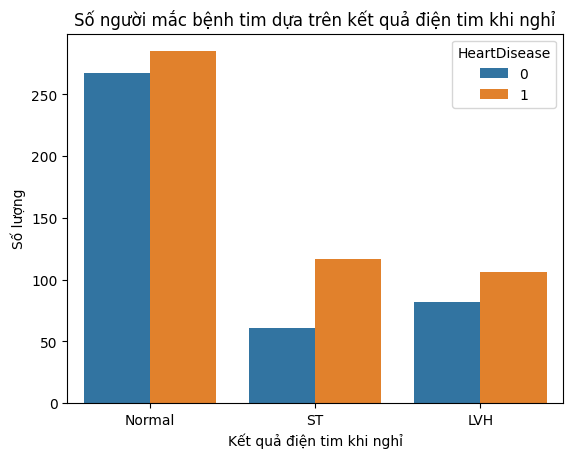

In [16]:
# RestingECG vs HeartDisease
sns.countplot(x="RestingECG", hue="HeartDisease", data=pandas_df)
plt.title("Số người mắc bệnh tim dựa trên kết quả điện tim khi nghỉ")
plt.xlabel("Kết quả điện tim khi nghỉ")
plt.ylabel("Số lượng")
plt.show()

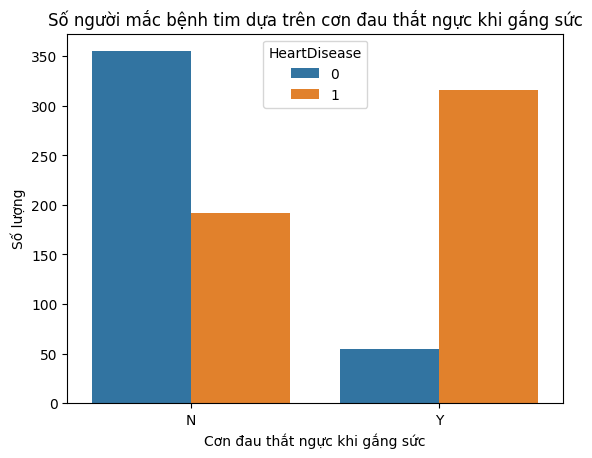

In [17]:
# ExerciseAngina vs HeartDisease
sns.countplot(x="ExerciseAngina", hue="HeartDisease", data=pandas_df)
plt.title("Số người mắc bệnh tim dựa trên cơn đau thắt ngực khi gắng sức")
plt.xlabel("Cơn đau thắt ngực khi gắng sức")
plt.ylabel("Số lượng")
plt.show()

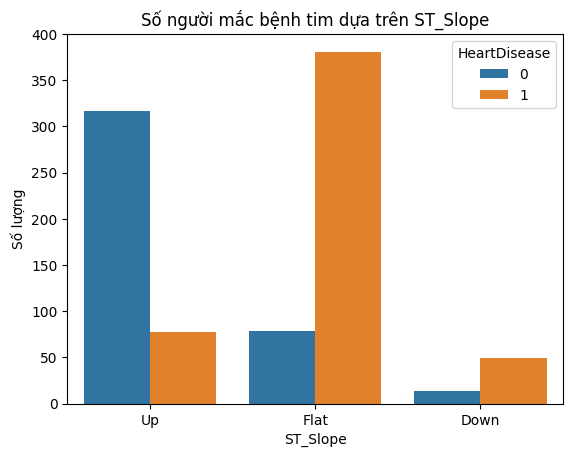

In [18]:
# ST_Slope vs HeartDisease
sns.countplot(x="ST_Slope", hue="HeartDisease", data=pandas_df)
plt.title("Số người mắc bệnh tim dựa trên ST_Slope")
plt.xlabel("ST_Slope")
plt.ylabel("Số lượng")
plt.show()

__Phân phối dữ liệu của các biến numerical với biến mục tiêu__

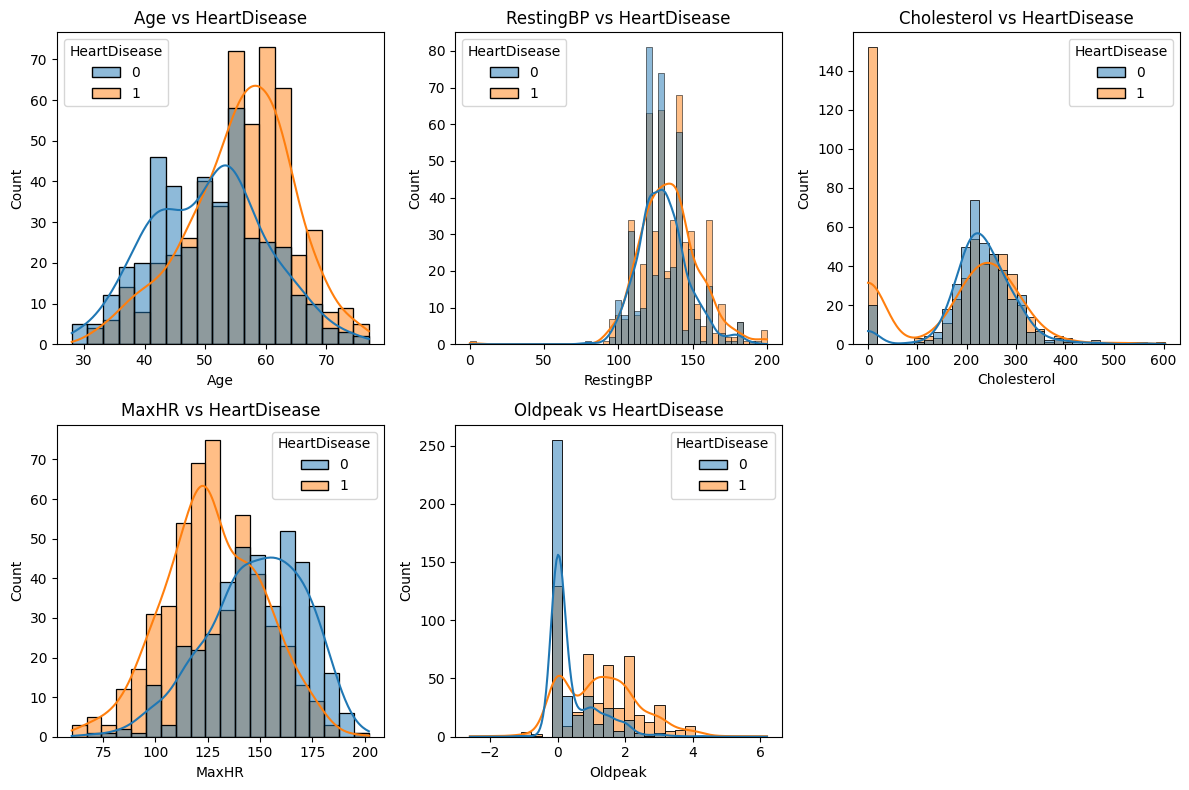

In [19]:
numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Histogram nhiều biến
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=pandas_df, x=feature, hue="HeartDisease", kde=True, ax=axes[i])
    axes[i].set_title(f"{feature} vs HeartDisease")

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

**1. Age vs HeartDisease**

- Người mắc bệnh tim (màu cam) có xu hướng cao tuổi hơn so với người không mắc bệnh tim.
- Đỉnh phân phối của nhóm mắc bệnh tim lệch phải, cho thấy nguy cơ mắc bệnh tăng lên theo tuổi.

**2. RestingBP vs HeartDisease (Huyết áp khi nghỉ)**

- Huyết áp nghỉ ngơi của cả hai nhóm có phân phối khá tương đồng, tập trung chủ yếu trong khoảng 120-140 mmHg.
- Không có sự khác biệt rõ rệt giữa hai nhóm.

**3. Cholesterol vs HeartDisease**

- Có một lượng lớn bệnh nhân không mắc bệnh tim có mức cholesterol rất thấp, có thể do điều trị hoặc đặc điểm của tập dữ liệu.
- Nhìn chung, phân phối cholesterol giữa hai nhóm khá tương đồng, nhưng có xu hướng hơi cao hơn ở nhóm mắc bệnh tim.

**4. MaxHR vs HeartDisease (Nhịp tim tối đa đạt được)**

- Người mắc bệnh tim có xu hướng có nhịp tim tối đa thấp hơn so với người không mắc bệnh tim.
- Điều này có thể liên quan đến việc tim của họ không thể đạt đến mức nhịp tim cao do các vấn đề về tuần hoàn.

**5. Oldpeak vs HeartDisease (Độ chênh ST trong ECG khi vận động so với lúc nghỉ)**

- Người mắc bệnh tim có giá trị Oldpeak cao hơn, điều này có thể liên quan đến dấu hiệu thiếu máu cục bộ (ischemia).
- Phân phối của nhóm mắc bệnh tim bị lệch phải, cho thấy rằng mức độ nghiêm trọng của sự chênh lệch ST có thể là một yếu tố quan trọng trong dự đoán bệnh tim.

**Tóm tắt**:
Age, MaxHR, và Oldpeak có ảnh hưởng đáng kể đến nguy cơ mắc bệnh tim.
RestingBP và Cholesterol không có sự khác biệt rõ rệt giữa hai nhóm.
MaxHR thấp và Oldpeak cao là những dấu hiệu đáng chú ý ở nhóm mắc bệnh tim.

**Phân phối dữ liệu giữa độ tuổi và các đặc trưng khác**

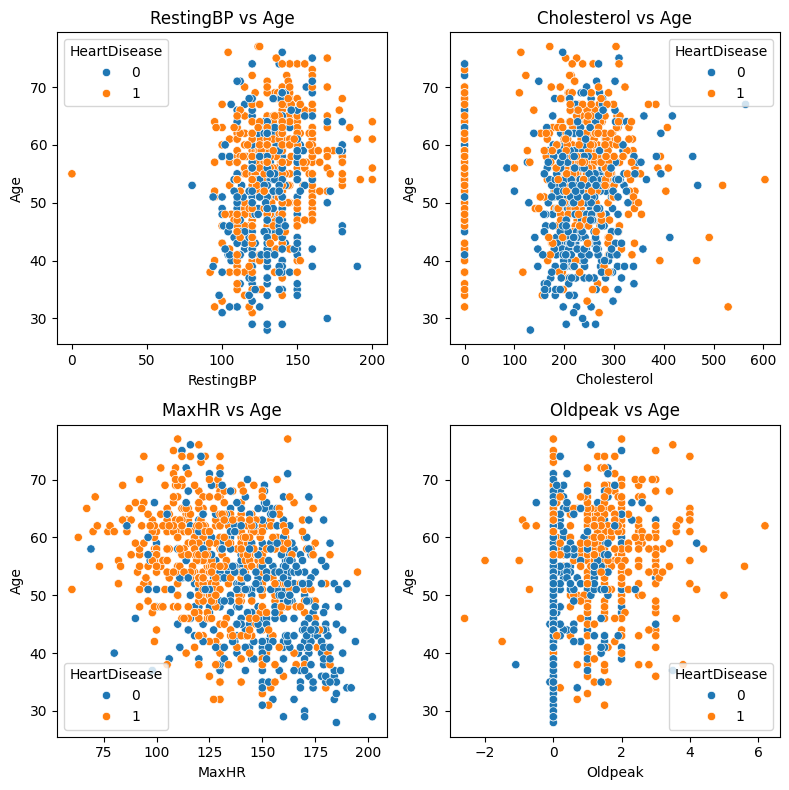

In [20]:
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features[1:]):  # bỏ Age
    sns.scatterplot(data=pandas_df, x=feature, y="Age", hue="HeartDisease", ax=axes[i])
    axes[i].set_title(f"{feature} vs Age")

plt.tight_layout()
plt.show()

__Kiểm tra mất cân bằng dữ liệu__

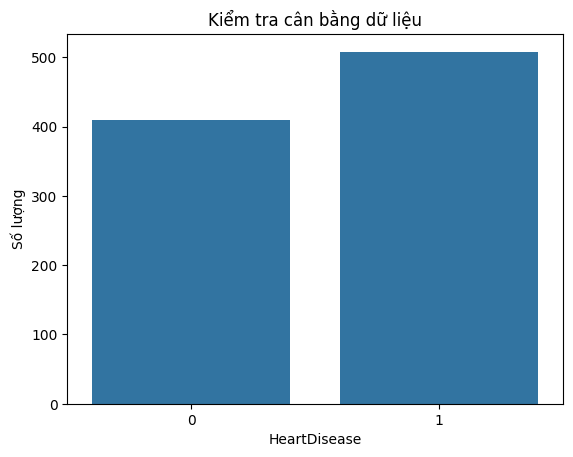

In [21]:
# HeartDisease distribution
sns.countplot(x="HeartDisease", data=pandas_df)
plt.title("Kiểm tra cân bằng dữ liệu")
plt.xlabel("HeartDisease")
plt.ylabel("Số lượng")
plt.show()

__Ma trận tương quan__

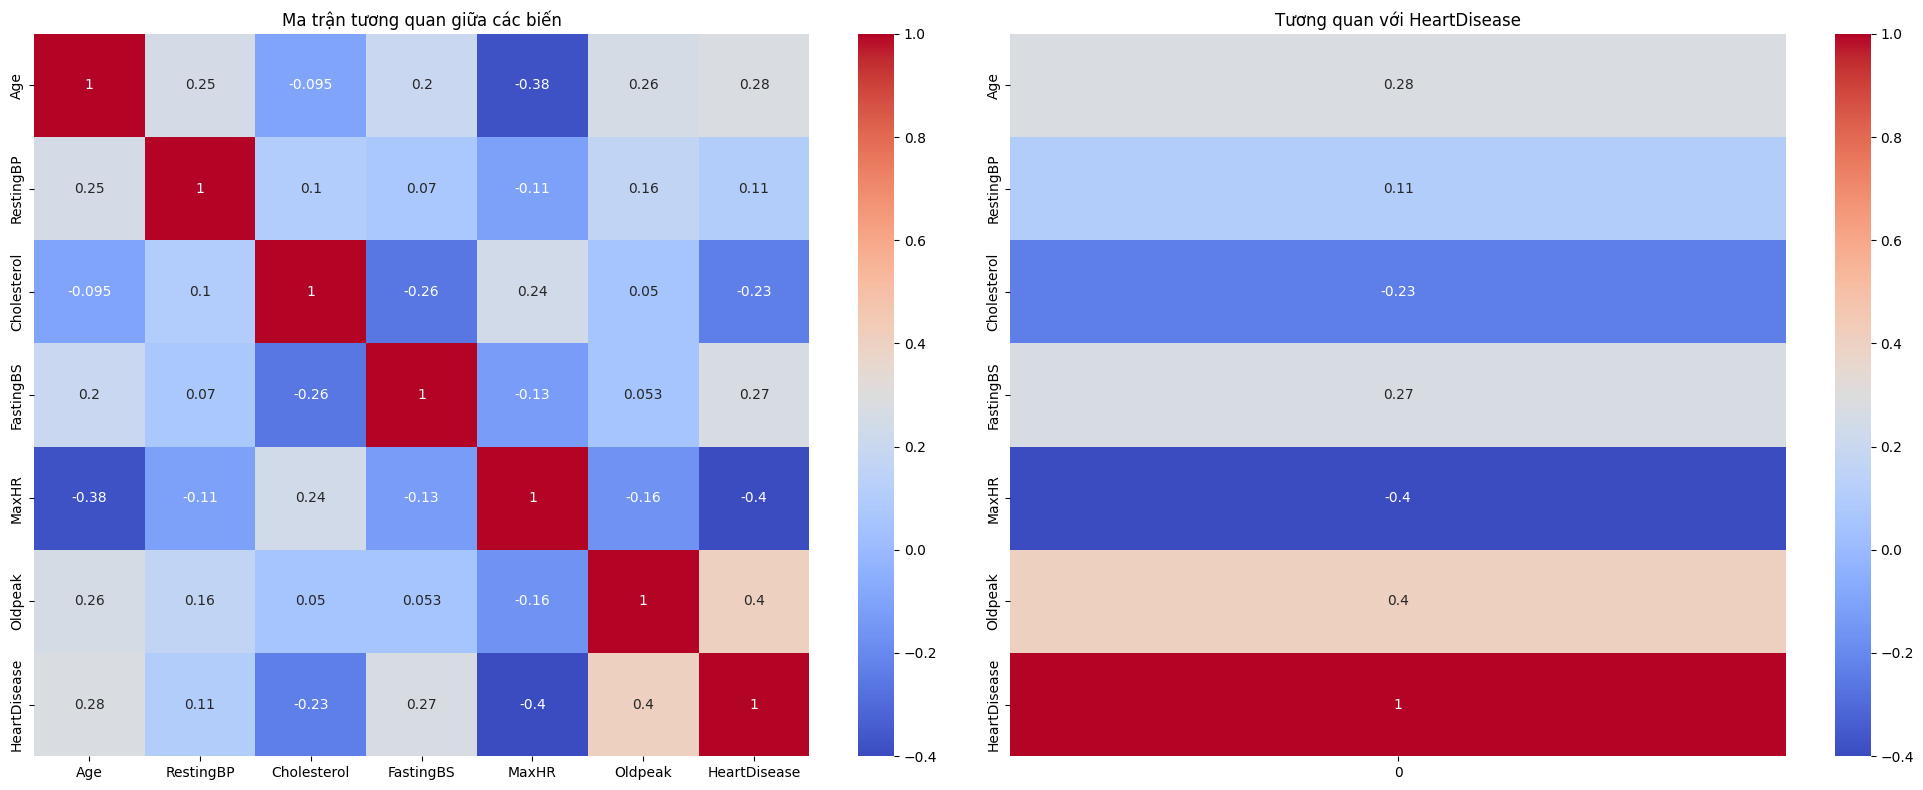

In [22]:
# Convert từ Spark DataFrame về Pandas DataFrame cho trực quan hóa
pandas_df_encoded = df.toPandas()

# Loại bỏ các cột dạng vector và các cột gốc dạng chuỗi
vector_cols = [
    col
    for col in pandas_df_encoded.columns
    if pandas_df_encoded[col]
    .apply(lambda x: isinstance(x, list) or "DenseVector" in str(type(x)))
    .any()
]
original_categorical_cols = [
    "Sex",
    "ChestPainType",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]
pandas_df_encoded = pandas_df_encoded.drop(
    columns=vector_cols + original_categorical_cols
)


# Vẽ heatmap tương quan
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(pandas_df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Ma trận tương quan giữa các biến")

plt.subplot(1, 2, 2)
sns.heatmap(
    pandas_df_encoded.corrwith(pandas_df_encoded["HeartDisease"]).to_frame(),
    annot=True,
    cmap="coolwarm",
)
plt.title("Tương quan với HeartDisease")

plt.tight_layout()
plt.show()

__Tiền xử lý dữ liệu__

In [23]:
# Các cột dạng chuỗi cần mã hóa
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

# Mã hóa bằng StringIndexer
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols
]

for indexer in indexers:
    df = indexer.fit(df).transform(df)

# Thay thế cột cũ bằng cột đã mã hóa
for col_name in categorical_cols:
    df = df.drop(col_name).withColumnRenamed(col_name + "_index", col_name)

In [24]:
df.show(5)

+---+---------+-----------+---------+-----+-------+------------+---+-------------+----------+--------------+--------+
|Age|RestingBP|Cholesterol|FastingBS|MaxHR|Oldpeak|HeartDisease|Sex|ChestPainType|RestingECG|ExerciseAngina|ST_Slope|
+---+---------+-----------+---------+-----+-------+------------+---+-------------+----------+--------------+--------+
| 40|      140|        289|        0|  172|    0.0|           0|0.0|          2.0|       0.0|           0.0|     1.0|
| 49|      160|        180|        0|  156|    1.0|           1|1.0|          1.0|       0.0|           0.0|     0.0|
| 37|      130|        283|        0|   98|    0.0|           0|0.0|          2.0|       2.0|           0.0|     1.0|
| 48|      138|        214|        0|  108|    1.5|           1|1.0|          0.0|       0.0|           1.0|     0.0|
| 54|      150|        195|        0|  122|    0.0|           0|0.0|          1.0|       0.0|           0.0|     1.0|
+---+---------+-----------+---------+-----+-------+-----

In [25]:
# Các cột dữ liệu dạng số
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Tạo vector đặc trưng ban đầu
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_feature")
df = assembler.transform(df)

# Chuẩn hóa dữ liệu số
scaler = StandardScaler(inputCol="numerical_feature", outputCol="scaled_feature")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Gộp tất cả các đặc trưng
all_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'scaled_feature']
assembler_all = VectorAssembler(inputCols=all_features, outputCol="features")
df = assembler_all.transform(df)

# Chọn cột cuối cùng để huấn luyện
final_df = df.select("features", col("HeartDisease").alias("label"))

In [26]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [27]:
# Danh sách mô hình
models = [
    LogisticRegression(labelCol="label", featuresCol="features"),
    RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100),
    GBTClassifier(labelCol="label", featuresCol="features"),
]

# Khởi tạo evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction"
)

# Variables to store fitted models for later use
rf_fitted_model = None
gbt_fitted_model = None

for model in models:
    print(f"\n=== {model.__class__.__name__} ===")
    fitted_model = model.fit(train_data)
    predictions = fitted_model.transform(test_data)

    # Store the fitted model if it's GBTClassifier or RandomForestClassifier
    if isinstance(model, RandomForestClassifier):
        rf_fitted_model = fitted_model
    elif isinstance(model, GBTClassifier):
        gbt_fitted_model = fitted_model

    # Accuracy
    evaluator.setMetricName("accuracy")
    acc = evaluator.evaluate(predictions)

    # Precision
    evaluator.setMetricName("weightedPrecision")
    prec = evaluator.evaluate(predictions)

    # Recall
    evaluator.setMetricName("weightedRecall")
    rec = evaluator.evaluate(predictions)

    # F1-score
    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(predictions)

    # In kết quả
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")


=== LogisticRegression ===
Accuracy: 0.8523
Precision: 0.8555
Recall: 0.8523
F1 Score: 0.8514

=== RandomForestClassifier ===
Accuracy: 0.8859
Precision: 0.8887
Recall: 0.8859
F1 Score: 0.8853

=== GBTClassifier ===
Accuracy: 0.8658
Precision: 0.8675
Recall: 0.8658
F1 Score: 0.8652


**Nhận xét:** Chọn ra 2 mô hình có chỉ số đánh giá cao nhất là Random Forest và Gradient Boosting để tiếp tục tối ưu hóa

##  Vì sao Recall quan trọng trong bài toán chẩn đoán phát hiện bệnh suy tim?

- Recall đo lường khả năng mô hình **phát hiện đúng** những bệnh nhân thật sự mắc bệnh.
- **Công thức**:
  $$
  Recall = \frac{TP}{TP + FN}
  $$
- **TP (True Positive):** Dự đoán đúng người có bệnh.
- **FN (False Negative):** Dự đoán **sai** là không bệnh nhưng thực tế **có bệnh** (bỏ sót bệnh nhân).

**Trong bài toán bệnh tim, bỏ sót bệnh nhân (FN) có thể gây hậu quả nghiêm trọng**:
- Nếu mô hình **bỏ sót bệnh nhân thực sự mắc bệnh (FN cao)**, họ có thể không được điều trị kịp thời.
- Trong y tế, một **FN nguy hiểm hơn FP** vì hậu quả sức khỏe có thể dẫn đến **biến chứng hoặc tử vong**.

**Ví dụ**:
- Nếu một bệnh nhân **bị bệnh tim thực sự** nhưng hệ thống chẩn đoán dự đoán **không bệnh** → Họ có thể không đi khám, bỏ lỡ cơ hội điều trị sớm.
- Ngược lại, nếu mô hình báo nhầm (**FP – dự đoán có bệnh nhưng thực tế không bệnh**), người đó chỉ phải làm thêm xét nghiệm, ít gây rủi ro.
**Vậy nên, cần ưu tiên Recall cao để hạn chế FN!**  

# **1. Random Forest**

**Feature Importance**

In [28]:
categorical_indexed = [
    "Sex",
    "ChestPainType",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

In [29]:
feature_names_for_importance = categorical_indexed + numerical_cols

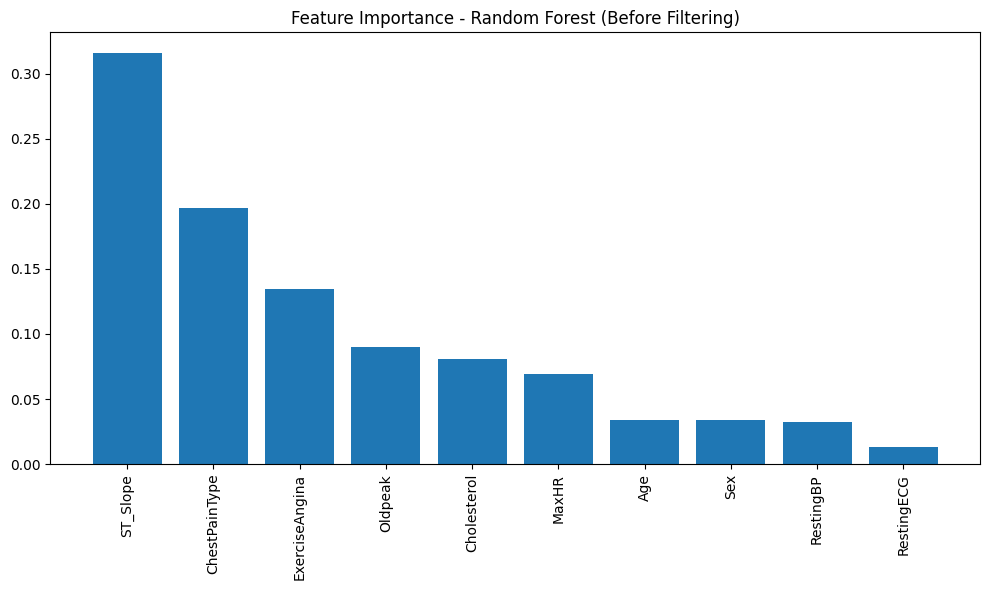

In [30]:
# Trích feature importances từ mô hình RF đã huấn luyện
importances = rf_fitted_model.featureImportances.toArray()
importances = importances[: len(feature_names_for_importance)]

# Ghép tên và giá trị importance
feature_importance_pairs = list(zip(feature_names_for_importance, importances))

# Sắp xếp giảm dần để biểu đồ đẹp
sorted_pairs_desc = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
features_sorted, importances_sorted = zip(*sorted_pairs_desc)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest (Before Filtering)")
plt.bar(range(len(importances_sorted)), importances_sorted, align="center")
plt.xticks(range(len(importances_sorted)), features_sorted, rotation=90)
plt.tight_layout()
plt.show()

__Loại bỏ đặc trưng ít quan trọng__

In [31]:
# Sắp xếp tăng dần để loại đặc trưng ít nhất
sorted_pairs = sorted(feature_importance_pairs, key=lambda x: x[1])

# Lấy danh sách đặc trưng đã loại bỏ 2 cái ít nhất
important_features = [feature for feature, _ in sorted_pairs[2:]]

print(
    "Các đặc trưng quan trọng (sau khi loại 2 đặc trưng ít nhất):", important_features
)

Các đặc trưng quan trọng (sau khi loại 2 đặc trưng ít nhất): ['Sex', 'Age', 'MaxHR', 'Cholesterol', 'Oldpeak', 'ExerciseAngina', 'ChestPainType', 'ST_Slope']


__Huấn luyện lại mô hình__

In [32]:
# Create a new assembler with only the important features
# Apply the assembler to the 'df' DataFrame which still contains individual columns
filtered_assembler = VectorAssembler(
    inputCols=important_features, outputCol="filtered_features"
)
data_filtered = filtered_assembler.transform(df)

# Select the filtered features and the label
final_data_filtered = data_filtered.select(
    "filtered_features", col("HeartDisease").alias("label")
)  # Use HeartDisease column


# Split the filtered data into training and testing sets
train_data_filtered, test_data_filtered = final_data_filtered.randomSplit(
    [0.8, 0.2], seed=42
)

In [33]:
# Huấn luyện lại mô hình Random Forest với các đặc trưng đã lọc
rf_new = RandomForestClassifier(
    labelCol="label", featuresCol="filtered_features", numTrees=100
)
rf_new_model = rf_new.fit(train_data_filtered)

# Đánh giá mô hình mới
predictions_filtered = rf_new_model.transform(test_data_filtered)

# Khởi tạo evaluator
evaluator_filtered = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction"
)

# Accuracy
evaluator_filtered.setMetricName("accuracy")
acc_filtered = evaluator_filtered.evaluate(predictions_filtered)

# Precision
evaluator_filtered.setMetricName("weightedPrecision")
prec_filtered = evaluator_filtered.evaluate(predictions_filtered)

# Recall
evaluator_filtered.setMetricName("weightedRecall")
rec_filtered = evaluator_filtered.evaluate(predictions_filtered)

# F1-score
evaluator_filtered.setMetricName("f1")
f1_filtered = evaluator_filtered.evaluate(predictions_filtered)

# In kết quả
print(f"\n=== RandomForestClassifier with Filtered Features ===")
print(f"Accuracy: {acc_filtered:.4f}")
print(f"Precision: {prec_filtered:.4f}")
print(f"Recall: {rec_filtered:.4f}")
print(f"F1 Score: {f1_filtered:.4f}")


=== RandomForestClassifier with Filtered Features ===
Accuracy: 0.8792
Precision: 0.8853
Recall: 0.8792
F1 Score: 0.8781


**Nhận thấy rằng kết quả sau khi huấn luyện lại mô hình kém hơn so với ban đầu -> tối ưu hóa trên tập dữ liệu gốc.**

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("\n=====================================================================")
print("### Bắt đầu Tối ưu hóa Siêu tham số trên TẬP DỮ LIỆU GỐC ###")
print("=====================================================================")

# Giả sử 'train_data' và 'test_data' là các tập dữ liệu gốc đã được chia
# với cột 'features' chứa TẤT CẢ các đặc trưng ban đầu.

# 1. Khởi tạo lại mô hình Random Forest
# Chúng ta sẽ dùng đối tượng này làm 'estimator' cho CrossValidator
rf_optimizer = RandomForestClassifier(labelCol="label", featuresCol="features")

# 2. Xây dựng lưới tham số (Parameter Grid)
# Đây là nơi bạn định nghĩa các giá trị siêu tham số mà bạn muốn thử nghiệm.
# Spark sẽ thử tất cả các kết hợp có thể.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf_optimizer.numTrees, [50, 100, 150])  # Số lượng cây
    .addGrid(rf_optimizer.maxDepth, [5, 10, 15])  # Độ sâu tối đa của mỗi cây
    .addGrid(rf_optimizer.maxBins, [32, 40])  # Số lượng bin để chia các biến liên tục
    .build()
)

# 3. Khởi tạo Evaluator
# Chúng ta sẽ sử dụng F1-score làm thước đo để chọn ra mô hình tốt nhất
evaluator_cv = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

# 4. Thiết lập CrossValidator
# - estimator: Mô hình bạn muốn tối ưu (rf_optimizer)
# - estimatorParamMaps: Lưới tham số bạn muốn thử (paramGrid)
# - evaluator: Thước đo để đánh giá hiệu suất (evaluator_cv)
# - numFolds: Số fold cho kiểm định chéo (cross-validation). 3 hoặc 5 là phổ biến.
crossval = CrossValidator(
    estimator=rf_optimizer,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_cv,
    numFolds=3,
    seed=42,
)

# 5. Huấn luyện mô hình với CrossValidator
# Spark sẽ huấn luyện nhiều mô hình (3 folds * 3 numTrees * 3 maxDepth * 2 maxBins = 54 mô hình)
# và tự động chọn ra mô hình có F1-score trung bình cao nhất trên các fold.
print("\nĐang chạy Cross-Validation... Quá trình này có thể mất vài phút.")
cv_model = crossval.fit(train_data)  # Sử dụng tập huấn luyện GỐC
print("Hoàn tất Cross-Validation.")

# cv_model bây giờ chính là mô hình tốt nhất được tìm thấy

# 6. Lấy ra các tham số tốt nhất
best_params = cv_model.bestModel.extractParamMap()
print("\nCác siêu tham số tốt nhất được tìm thấy:")
print(f"- numTrees: {best_params[cv_model.bestModel.numTrees]}")
print(f"- maxDepth: {best_params[cv_model.bestModel.maxDepth]}")
print(f"- maxBins: {best_params[cv_model.bestModel.maxBins]}")


# 7. Đánh giá mô hình đã được tối ưu trên tập kiểm tra (test_data)
predictions_optimized = cv_model.transform(test_data)

# Tính toán các chỉ số
# Accuracy
evaluator_cv.setMetricName("accuracy")
acc_optimized = evaluator_cv.evaluate(predictions_optimized)

# Precision
evaluator_cv.setMetricName("weightedPrecision")
prec_optimized = evaluator_cv.evaluate(predictions_optimized)

# Recall
evaluator_cv.setMetricName("weightedRecall")
rec_optimized = evaluator_cv.evaluate(predictions_optimized)

# F1-score
evaluator_cv.setMetricName("f1")
f1_optimized = evaluator_cv.evaluate(predictions_optimized)


# 8. In kết quả của mô hình đã tối ưu
print(f"\n=== RandomForestClassifier with Optimized Hyperparameters ===")
print(f"Accuracy: {acc_optimized:.4f}")
print(f"Precision: {prec_optimized:.4f}")
print(f"Recall: {rec_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}")


### Bắt đầu Tối ưu hóa Siêu tham số trên TẬP DỮ LIỆU GỐC ###

Đang chạy Cross-Validation... Quá trình này có thể mất vài phút.
Hoàn tất Cross-Validation.

Các siêu tham số tốt nhất được tìm thấy:
- numTrees: 150
- maxDepth: 5
- maxBins: 32

=== RandomForestClassifier with Optimized Hyperparameters ===
Accuracy: 0.8725
Precision: 0.8798
Recall: 0.8725
F1 Score: 0.8712


# **2. Gradient Boosting**

**Feature Importance**

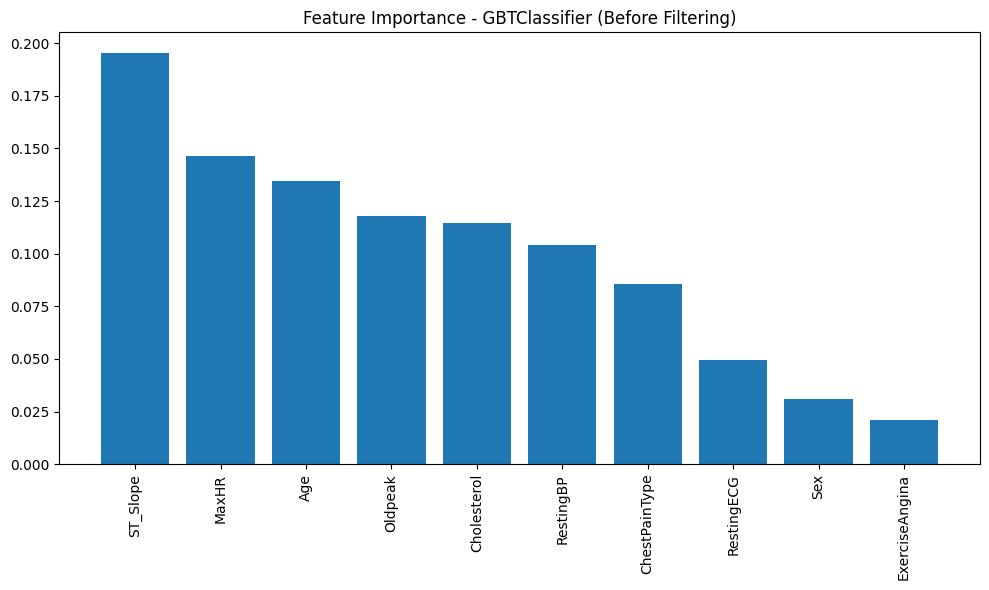

In [35]:
importances = gbt_fitted_model.featureImportances.toArray()
importances = importances[: len(feature_names_for_importance)]

feature_importance_pairs = list(zip(feature_names_for_importance, importances))

sorted_pairs_desc = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
features_sorted, importances_sorted = zip(*sorted_pairs_desc)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance - GBTClassifier (Before Filtering)")
plt.bar(range(len(importances_sorted)), importances_sorted, align="center")
plt.xticks(range(len(importances_sorted)), features_sorted, rotation=90)
plt.tight_layout()
plt.show()

**Loại bỏ đặc trưng ít quan trọng**

In [36]:
# Sắp xếp tăng dần để loại đặc trưng ít nhất
sorted_pairs = sorted(feature_importance_pairs, key=lambda x: x[1])

# Lấy danh sách đặc trưng đã loại bỏ 2 cái ít nhất
important_features = [feature for feature, _ in sorted_pairs[2:]]

print(
    "Các đặc trưng quan trọng (sau khi loại 2 đặc trưng ít nhất):", important_features
)

Các đặc trưng quan trọng (sau khi loại 2 đặc trưng ít nhất): ['RestingECG', 'ChestPainType', 'RestingBP', 'Cholesterol', 'Oldpeak', 'Age', 'MaxHR', 'ST_Slope']


**Huấn luyện lại mô hình**

In [37]:
from pyspark.ml.feature import VectorAssembler

# Tạo assembler mới
filtered_assembler = VectorAssembler(
    inputCols=important_features, outputCol="filtered_features"
)
data_filtered = filtered_assembler.transform(df)

# Dữ liệu sau khi đã biến đổi
final_data = data_filtered.select(
    "filtered_features", col("HeartDisease").alias("label")
)

In [38]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Tách tập train/test
train_data_filtered, test_data_filtered = final_data.randomSplit([0.8, 0.2], seed=42)

# Huấn luyện lại mô hình
gbt_new = GBTClassifier(labelCol="label", featuresCol="filtered_features", maxIter=50)
gbt_new_model = gbt_new.fit(train_data_filtered)

# Dự đoán
predictions_filtered = gbt_new_model.transform(test_data_filtered)

# Đánh giá
evaluator_filtered = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction"
)

evaluator_filtered.setMetricName("accuracy")
acc_filtered = evaluator_filtered.evaluate(predictions_filtered)

evaluator_filtered.setMetricName("weightedPrecision")
prec_filtered = evaluator_filtered.evaluate(predictions_filtered)

evaluator_filtered.setMetricName("weightedRecall")
rec_filtered = evaluator_filtered.evaluate(predictions_filtered)

evaluator_filtered.setMetricName("f1")
f1_filtered = evaluator_filtered.evaluate(predictions_filtered)

print(f"\n=== GBTClassifier with Filtered Features ===")
print(f"Accuracy: {acc_filtered:.4f}")
print(f"Precision: {prec_filtered:.4f}")
print(f"Recall: {rec_filtered:.4f}")
print(f"F1 Score: {f1_filtered:.4f}")


=== GBTClassifier with Filtered Features ===
Accuracy: 0.8322
Precision: 0.8330
Recall: 0.8322
F1 Score: 0.8317


**Nhận thấy rằng kết quả sau khi huấn luyện lại mô hình kém hơn so với ban đầu -> tối ưu hóa trên tập dữ liệu gốc.**

In [39]:
from pyspark.ml.classification import GBTClassifier

# Khởi tạo GBT
gbt = GBTClassifier(labelCol="label", featuresCol="filtered_features")

# Lưới tham số
paramGrid_gbt = (
    ParamGridBuilder()
    .addGrid(gbt.maxIter, [20, 50])
    .addGrid(gbt.maxDepth, [3, 5])
    .build()
)

# CrossValidator
cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction"
    ),
    numFolds=3,
)

# Train
gbt_cv_model = cv_gbt.fit(train_data_filtered)

# Dự đoán
pred_gbt = gbt_cv_model.transform(test_data_filtered)

In [40]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("\n=====================================================================")
print("### Bắt đầu Tối ưu hóa Siêu tham số cho GBT Classifier ###")
print("=====================================================================")

# 1. Khởi tạo mô hình GBT Classifier
# Chúng ta sẽ dùng đối tượng này làm 'estimator' cho CrossValidator
gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=42)

# 2. Xây dựng lưới tham số (Parameter Grid) cho GBT
# - maxIter: Số vòng lặp boosting (số cây).
# - maxDepth: Độ sâu tối đa của mỗi cây quyết định.
# - stepSize: Tốc độ học (learning rate), kiểm soát mức độ đóng góp của mỗi cây.
paramGrid_gbt = (
    ParamGridBuilder()
    .addGrid(gbt.maxIter, [20, 50, 70])  # Số vòng lặp
    .addGrid(gbt.maxDepth, [3, 5, 7])  # Độ sâu tối đa
    .addGrid(gbt.stepSize, [0.1, 0.05])  # Tốc độ học
    .build()
)

# 3. Khởi tạo Evaluator
# Tiếp tục sử dụng F1-score để chọn ra mô hình tốt nhất
evaluator_gbt = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

# 4. Thiết lập CrossValidator cho GBT
crossval_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator_gbt,
    numFolds=3,  # Sử dụng 3-fold cross-validation
    seed=42,
)

# 5. Huấn luyện mô hình với CrossValidator
print(
    "\nĐang chạy Cross-Validation cho GBT... Quá trình này có thể mất nhiều thời gian hơn RF."
)
cv_model_gbt = crossval_gbt.fit(train_data)  # Sử dụng tập huấn luyện GỐC
print("Hoàn tất Cross-Validation cho GBT.")

# cv_model_gbt bây giờ là mô hình GBT tốt nhất được tìm thấy

# 6. Lấy ra các tham số tốt nhất
best_params_gbt = cv_model_gbt.bestModel.extractParamMap()
print("\nCác siêu tham số tốt nhất được tìm thấy cho GBT:")
print(f"- maxIter: {best_params_gbt[cv_model_gbt.bestModel.maxIter]}")
print(f"- maxDepth: {best_params_gbt[cv_model_gbt.bestModel.maxDepth]}")
print(f"- stepSize: {best_params_gbt[cv_model_gbt.bestModel.stepSize]}")

# 7. Đánh giá mô hình GBT đã được tối ưu trên tập kiểm tra (test_data)
predictions_gbt_optimized = cv_model_gbt.transform(test_data)

# Tính toán các chỉ số
# Accuracy
evaluator_gbt.setMetricName("accuracy")
acc_gbt_optimized = evaluator_gbt.evaluate(predictions_gbt_optimized)

# Precision
evaluator_gbt.setMetricName("weightedPrecision")
prec_gbt_optimized = evaluator_gbt.evaluate(predictions_gbt_optimized)

# Recall
evaluator_gbt.setMetricName("weightedRecall")
rec_gbt_optimized = evaluator_gbt.evaluate(predictions_gbt_optimized)

# F1-score
evaluator_gbt.setMetricName("f1")
f1_gbt_optimized = evaluator_gbt.evaluate(predictions_gbt_optimized)

# 8. In kết quả của mô hình GBT đã tối ưu
print(f"\n=== GBT Classifier with Optimized Hyperparameters ===")
print(f"Accuracy: {acc_gbt_optimized:.4f}")
print(f"Precision: {prec_gbt_optimized:.4f}")
print(f"Recall: {rec_gbt_optimized:.4f}")
print(f"F1 Score: {f1_gbt_optimized:.4f}")


### Bắt đầu Tối ưu hóa Siêu tham số cho GBT Classifier ###

Đang chạy Cross-Validation cho GBT... Quá trình này có thể mất nhiều thời gian hơn RF.
Hoàn tất Cross-Validation cho GBT.

Các siêu tham số tốt nhất được tìm thấy cho GBT:
- maxIter: 70
- maxDepth: 3
- stepSize: 0.1

=== GBT Classifier with Optimized Hyperparameters ===
Accuracy: 0.8725
Precision: 0.8737
Recall: 0.8725
F1 Score: 0.8721
